# Cat and Dog with Google Inception modules<hr/>

### So What are Inception modules? How looks Google Inception Module ?

<img src="./inception.png" width=700px>

it's Google inception module and it used in GoogLeNet model 





### What is different from a normal inception module?


<img src="./normal_inception.png" width=700px>

The Normal Inception module does not use 1x1 convolution, So I'm asking 'why is Google Inception module using 1x1 convolution'?

Because the large convolutions require a lot of computation. But they wanted to be deeper and wider with less computation.

that's why there are 1x1 convolution before doing large convolution (in this case 5x5 and 3x3 !)

in fact, 1x1 convolution reduces the calculation

How 1x1 convolution reduces the calculation?

The key is dimensionality reduction with 1x1 convolution

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random
print(os.listdir())

C:\Users\che99\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['.ipynb_checkpoints', 'inception.png', 'main_Simple_CNN.ipynb', 'main_with_google_inception.ipynb', 'normal_inception.png', 'test_set', 'training_set']


In [2]:
TRAINING_DIR = './training_set/training_set/'
TEST_DIR = './test_set/test_set/'

## get data and labeling 

cat and dog datas from kaggle 'https://www.kaggle.com/tongpython/cat-and-dog'

many other people converts the images to grayscale when input images, but i will not converts the images to grayscale

So you need to ask "why we removed the color? don't we need the color to classification?" 

It depends on object of classification. I found information about this story. they will help you understand

https://www.quora.com/How-does-convolutional-Neural-Network-handle-color-images-in-object-recognition?srid=ddVE

https://github.com/GilLevi/AgeGenderDeepLearning/issues/4

https://www.reddit.com/r/MachineLearning/comments/5h2l09/d_cnn_object_recognition_grayscale_vs_rgb/


In [3]:
def get_data(name):
    x = []
    y = []
    for Dir in os.listdir(name):
        if not Dir.startswith('.'):
            if Dir in ['cats']:
                value = 0
            elif Dir in ['dogs']:
                value = 1
                
            for file in os.listdir(name+'/'+Dir):
                img = cv2.imread(name+'/'+Dir+'/'+file) # read img and removed colors
                if img is not None:
                    img = cv2.resize(img,(50, 50))
                    img = np.array(img)
                    x.append(img)
                    y.append(value)
    return np.array(x), np.array(y)

In [4]:
trainx, trainy = get_data(TRAINING_DIR)

In [5]:
testx, testy = get_data(TEST_DIR)

## Check datas shape and sample image

In [6]:
print(trainx.shape, trainy.shape)
print(testx.shape, testy.shape)

(8005, 50, 50, 3) (8005,)
(2023, 50, 50, 3) (2023,)


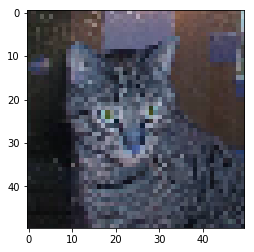

In [7]:
plt.imshow(trainx[0],cmap='Greys_r')
plt.show()

## Code BatchGenerator
i made it for long time ago, and it's pretty useful ! every time when i do deepleaning

In [8]:
class BatchGenerator():
    where = 0
    
    def __init__(self, x, y, batch_size, one_hot = False, nb_classes = 0):
        self.nb_classes = nb_classes
        self.one_hot = one_hot
        self.x_ = x
        self.y_ = y
        self.batch_size = batch_size
        
        self.total_batch = int(len(x) / batch_size)
        self.x = self.x_[:batch_size,]
        self.y = self.y_[:batch_size,]
        self.where = batch_size
        
        if self.one_hot :
            self.set_one_hot()

    def next_batch(self):
        if self.where + self.batch_size > len(self.x_) :
            self.where = len(self.x_) - self.where
            
        self.x = self.x_[self.where:self.where+self.batch_size,]
        self.y = self.y_[self.where:self.where+self.batch_size,]
        self.where += self.batch_size
        
        if self.one_hot:
            self.set_one_hot()
        
    def set_one_hot(self):
        self.y = np.int32(self.y)
        one_hot = np.array(self.y).reshape(-1)
        self.y = np.eye(self.nb_classes)[one_hot]
        

## Some of functions to building Neural Network

In [9]:
def create_weight(size, name):
    return tf.Variable(tf.random_normal(size, dtype=tf.float32, stddev=0.01), name = name)
    
def create_bias(size,name):
    return tf.Variable(tf.random_normal(size, dtype=tf.float32, stddev=0.01), name = name)

def conv2d(x,W):
    return tf.nn.conv2d(x,W, strides=[1,1,1,1], padding='SAME')

def max_pooling(x, size, strides):
    return tf.nn.max_pool(x, ksize=size, strides=strides, padding='SAME')

## Set Variables for CNN
yeah... it's pretty messy but you will easily understand if you read slowly line to line 

I've only used two Google Inception modules, and one of the hidden layers is fully connected.

also, only the last two of the variable weights use the xavier initializer

Understanding Xavier Initialization In Deep Neural Networks 

'https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/'

In [10]:
# placeholders for input datas
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, 50, 50, 3])
Y = tf.placeholder(tf.float32, shape=[None, 2])

In [11]:
# for first inception module 
W1_1 = create_weight([1,1,3,32],'w1_1')
b1_1 = create_weight([32],'b1_1')
W1_2 = create_weight([1,1,3,16],'w1_2')
b1_2 = create_weight([16],'b1_2')
W1_3 = create_weight([1,1,3,16],'w1_3')
b1_3 = create_weight([16],'b1_3')
W1_4 = create_weight([1,1,3,32],'w1_4')
b1_4 = create_weight([32],'b1_4')

W1_3x3 = create_weight([3,3,16,32],'w1_3x3')
b1_3x3 = create_weight([32],'b1_3x3')
W1_5x5 = create_weight([5,5,16,32],'w1_5x5')
b1_5x5 = create_weight([32],'b1_5x5')

# for second inception module 
W2_1 = create_weight([1,1,32*4,64],'w2_1')
b2_1 = create_weight([64],'b2_1')
W2_2 = create_weight([1,1,32*4,16],'w2_2')
b2_2 = create_weight([16],'b2_2')
W2_3 = create_weight([1,1,32*4,16],'w2_3')
b2_3 = create_weight([16],'b2_3')
W2_4 = create_weight([1,1,32*4,64],'w2_4')
b2_4 = create_weight([64],'b2_4')

W2_3x3 = create_weight([3,3,16,64],'w2_3x3')
b2_3x3 = create_weight([64],'b2_3x3')
W2_5x5 = create_weight([5,5,16,64],'w2_5x5')
b2_5x5 = create_weight([64],'b2_5x5')

In [12]:
# for full connected layer
W_out1 = tf.get_variable('W_out1', shape=[50 * 50 * 256, 512],initializer = tf.contrib.layers.xavier_initializer())
b_out1 = create_bias([512],'b_out1')
W_out2 = tf.get_variable('W_out2', shape=[512, 2],initializer = tf.contrib.layers.xavier_initializer())
b_out2 = create_bias([2],'b_out2')

## preparing to training
we will use AdamOptimizer, It's awesome You can find some posts or information on Google

In [13]:
def model(x, train = True):
    
    conv1_1 = conv2d(X, W1_1) + b1_1
    conv1_2 = conv2d(tf.nn.relu(conv2d(X, W1_2) + b1_2), W1_3x3) + b1_3x3
    conv1_3 = conv2d(tf.nn.relu(conv2d(X, W1_3) + b1_3), W1_5x5) + b1_5x5
    conv1_4 = conv2d(max_pooling(X, [1,3,3,1],[1,1,1,1]), W1_4) + b1_4
    inception1 = tf.nn.relu(tf.concat([conv1_1, conv1_2, conv1_3, conv1_4], 3))
    
    conv2_1 = conv2d(inception1, W2_1) + b2_1
    conv2_2 = conv2d(tf.nn.relu(conv2d(inception1, W2_2) + b2_2), W2_3x3) + b2_3x3
    conv2_3 = conv2d(tf.nn.relu(conv2d(inception1, W2_3) + b2_3), W2_5x5) + b2_5x5
    conv2_4 = conv2d(max_pooling(inception1, [1,3,3,1],[1,1,1,1]), W2_4) + b2_4
    inception2 = tf.nn.relu(tf.concat([conv2_1, conv2_2, conv2_3, conv2_4], 3))
    
    FC_1 = tf.reshape(inception2, [-1, 50*50*256])
    
    
    if train:
        FC_1 = tf.nn.relu(tf.matmul(FC_1, W_out1) + b_out1)
        FC_1 = tf.nn.dropout(FC_1, keep_prob=0.5)
    
    else:
        FC_1 = tf.nn.relu(tf.matmul(FC_1, W_out1) + b_out1)
    
    FC_2 = tf.matmul(FC_1, W_out2) + b_out2
    
    return FC_2

In [14]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model(X), labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Let's Training!
you may want to see how your model is going , so it will show 'cost(==lost) value' every epoch

total 300 epoches it took 2~3 hours, with gtx 1080 ti 11g  

In [21]:
batch = BatchGenerator(trainx, trainy, batch_size=50, nb_classes=2, one_hot=True)
epoches = 100

print('started!')
for epoch in range(epoches):
    avg_cost = 0
    for i in range(batch.total_batch):
        feed_dict = {X: batch.x, Y: batch.y}
        c, _, = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / batch.total_batch
        batch.next_batch()
    print('Epoch:' '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))        

started!
Epoch:0001 cost = 0.002462188
Epoch:0002 cost = 0.003317559
Epoch:0003 cost = 0.001438024
Epoch:0004 cost = 0.001781755
Epoch:0005 cost = 0.001757527
Epoch:0006 cost = 0.002518931
Epoch:0007 cost = 0.002705596
Epoch:0008 cost = 0.002880494
Epoch:0009 cost = 0.002921518
Epoch:0010 cost = 0.002437121
Epoch:0011 cost = 0.002351077
Epoch:0012 cost = 0.001880874
Epoch:0013 cost = 0.002788764
Epoch:0014 cost = 0.003718139
Epoch:0015 cost = 0.002490619
Epoch:0016 cost = 0.002420949
Epoch:0017 cost = 0.001715997
Epoch:0018 cost = 0.001996153
Epoch:0019 cost = 0.002027520
Epoch:0020 cost = 0.001106940
Epoch:0021 cost = 0.001386371
Epoch:0022 cost = 0.001749489
Epoch:0023 cost = 0.001659661
Epoch:0024 cost = 0.002298129
Epoch:0025 cost = 0.001964607
Epoch:0026 cost = 0.001092294
Epoch:0027 cost = 0.001875240
Epoch:0028 cost = 0.001401207
Epoch:0029 cost = 0.002463883
Epoch:0030 cost = 0.001726837
Epoch:0031 cost = 0.001587292
Epoch:0032 cost = 0.001239690
Epoch:0033 cost = 0.001712939
E

## Check Accuracy and Test the model with test datas

In [22]:
correct_prediction = tf.equal(tf.argmax(model(X, False), 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('----- TRAIN DATA ACCURACY -----')
accu  = 0
batch = BatchGenerator(trainx, trainy, batch_size=50, nb_classes=2,one_hot=True)
for i in range(batch.total_batch):
    feed_dict = {X:batch.x, Y:batch.y}
    accu += sess.run(accuracy, feed_dict=feed_dict)
    batch.next_batch()

print( (accu / batch.total_batch) * 100 , '%' )


print('----- TEST DATA ACCURACY -----')
accu  = 0
test = BatchGenerator(testx, testy, batch_size=50,one_hot=True, nb_classes=2)
for i in range(test.total_batch):
    feed_dict = {X:test.x, Y:test.y}
    accu += sess.run(accuracy, feed_dict=feed_dict)
    test.next_batch()

print( (accu / test.total_batch) * 100 , '%' )

----- TRAIN DATA ACCURACY -----
100.0 %
----- TEST DATA ACCURACY -----
73.10000017285347 %


## 73 % accuracy! for test datas, you wanna see as image? 

i expected more accuracy for test data but there are only two of inception modules and 8005 of training data set

but there is one thing we should do 

OpenCV represents RGB images as multi-dimensional NumPy arrays and  in reverse order

This means that images are actually represented in BGR order rather than RGB!

There’s an easy fix though.

All we need to do is convert the image from BGR to RGB using cv2 before input to plt.plot

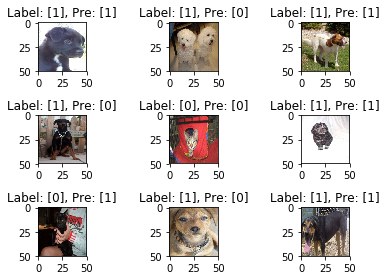

In [23]:
test = BatchGenerator(testx, testy, batch_size=len(testx),one_hot=True, nb_classes=2)

for i in range(9):
    
    r = random.randint(0, len(test.x))
    plt.subplot(3,3,i+1)

    plt.title('Label: {}, Pre: {}'.format(sess.run(tf.argmax(test.y[r:r+1], 1)),
                                                  sess.run(tf.argmax(model(X), 1), 
                                                           feed_dict={X: test.x[r:r+1]})))
    b,g,r = cv2.split(test.x[r])
    plt.imshow( cv2.merge([r,g,b]))
    plt.tight_layout()